# What is Neuron?

- neuron simulation software
- fast and efficient, with large databases 

# How does NEURON work? 

- written in HOC language interpreter 
- now have python support
- and add extra emmbrane mechanism using NMODL files

## Modelling axons

- membrane modelled as resistance and capicitance
- also modelled in terms of sections into segments

In [1]:
import neuron 
soma = neuron.h.Section() # set up a 'section'; abstract representation of a neuron, divided into segments
# all section goes from 0 to 1 (two different ends), and are divided into segments
dend = neuron.h.Section() # dendrite
dend.connect(soma(1)) # connect dendrite to '1-end' segment of soma

__nrnsec_0x21be420

Distributed mechanisms and point processes: 

- *distributed mechanism* is attributed to the entire section 
    - eg. passive membrane current
- a *point process* is specified at a single point along the section
    - eg. voltage clamp

Going beyond passive (pas) and Hogkin-Huxley (hh)

- requires NMODL 


# Passive Properties

## Make a ball model 

{'point_processes': {}, 'density_mechs': {'pas': {'g': [0.001], 'e': [-70.0], 'i': [0.0]}}, 'ions': {}, 'morphology': {'L': 12.6157, 'diam': [12.6157], 'pts3d': [], 'parent': None, 'trueparent': None}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'soma', 'hoc_internal_name': '__nrnsec_0x2472300', 'cell': None}
|-|       soma(0-1)
|-|       soma(0-1)



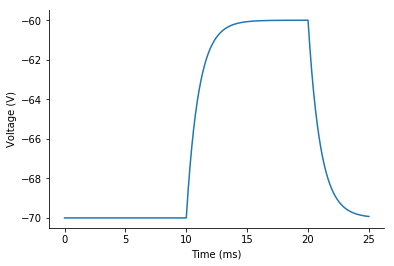

Input resistance is 199988546.61
Membrane resistance is 0.10
The Tau_M from theory is 0.10
-63.679156407984614
The Tau_M from experiment is 10.90


In [14]:
import neuron
from neuron import gui
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
soma = neuron.h.Section(name='soma')
# dend = neuron.h.Section(name='dend')
# dend.connect(soma(1))

soma.L = 12.6157# 100 # 12.6157
soma.diam = 12.6157 # 500 #12.6157

soma.insert('pas')
print(soma.psection())

# neuron.h.delete_section('dend')

# Ri: input resistance
neuron.h.topology()

# add point process: current injection 
stim = neuron.h.IClamp(soma(0.5))
stim.delay = 10
stim.dur = 10 # ms
stim.amp = 0.05 # nA

# measuring Ri and mTau
# input_resistance_store = neuron.h.vector()
# input_resistance_store.record()
voltage = neuron.h.Vector()

# measure voltage 
voltage.record(soma(0.5)._ref_v)


m_tau_store = neuron.h.Vector()
time = neuron.h.Vector()
time.record(h._ref_t)

# run 
total_time = 25
neuron.h.load_file('stdrun.hoc')
neuron.h.tstop = total_time
h.v_init = -70 # initial voltage
neuron.h.run() # ms

plt.figure()
# s = neuron.h.Shape()
import seaborn as sns 
time_np = time.as_numpy()
voltage_np = voltage.as_numpy()
ax = sns.lineplot(time_np, voltage_np)
ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
sns.despine()
plt.show()

# print(time)
# print(time_np)
# print(voltage_np)

# calculating the input resistance 
delta_V = (max(voltage_np) - min(voltage_np)) * 10**(-3)
delta_Ie = 0.05 * 10**(-9)
input_resistance = delta_V / delta_Ie
print('Input resistance is %.2f' % input_resistance)


# calculating Tau_m (time constant)
R_i = input_resistance
circum =  soma.diam  * np.pi 
length = soma.L
A = (circum * 10**(-6)) * (length * 10 ** (-6)) 
R_m = R_i * A

print('Membrane resistance is %.2f' % R_m)
C_m = soma.cm
tau_m = R_m * C_m 
print('The Tau_M from theory is %.2f' % tau_m)

# Finding tau empirically 
# print(max(voltage_np))
special_v = (max(voltage_np) - min(voltage_np)) * (1 - 1/np.e)
special_vv = special_v + min(voltage_np)
print(special_vv)
# tau_m_samp = 11 # where V = special_v

tauIndex = np.where(np.logical_and(voltage_np > special_vv - 0.5, voltage_np < special_vv + 0.5))
tau_m_samp = tauIndex[0][0]

tau_m_exp = time_np[tau_m_samp]
print('The Tau_M from experiment is %.2f' % tau_m_exp)


Input resistance is 199988546.61
TauM is -10.00


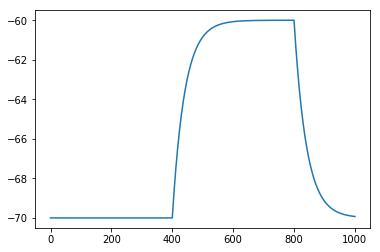

In [13]:
# writing things as a function 
import neuron 
from neuron import h, gui
import numpy as np
def run_ball_model():

    return 1 

def inject_current(soma = neuron.h.Section(name='soma'), somaLength = 12.6157,
somaDiam = 12.6157, stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25): 
    
    soma.insert('pas')
    soma.L = somaLength
    soma.diam = somaDiam 
    
    
    # add point process: current injection 
    stim = neuron.h.IClamp(soma(0.5))
    stim.delay = stimDelay
    stim.dur = stimDur # ms
    stim.amp = stimAmp # nA
    
    voltage = neuron.h.Vector()
    # measure voltage 
    voltage.record(soma(0.5)._ref_v)
    
    # measure time
    time = neuron.h.Vector()
    time.record(h._ref_t)
    
    neuron.h.load_file('stdrun.hoc')
    neuron.h.tstop = total_time
    h.v_init = -70 # initial voltage
    neuron.h.run() # ms
    
    time_np = time.as_numpy()
    voltage_np = voltage.as_numpy()
    
    return voltage_np, time_np
    

def cal_Ri(voltage_np, stimAmp = 0.05):
    
    delta_V = (max(voltage_np) - min(voltage_np)) * 10**(-3)
    delta_Ie = stimAmp * 10**(-9)
    input_resistance = delta_V / delta_Ie
    
    return input_resistance

def cal_TauM(voltage_np, time_np, stimDelay = 10):
    # from "experiment"
    special_v = (max(voltage_np) - min(voltage_np)) * (1 - 1/np.e)
    special_vv = special_v + min(voltage_np)
    # print(special_vv)
    # tau_m_samp = 11 # where V = special_v

    tauIndex = np.where(np.logical_and(voltage_np > special_vv - 0.5, voltage_np < special_vv + 0.5))
    tau_m_samp = tauIndex[0][0]

    tau_m_exp = time_np[tau_m_samp]
    
    TauM = tau_m_exp - stimDelay
    
    return TauM

# test run 
voltage_np, time_np = inject_current()

import seaborn as sns
sns.lineplot(np.arange(len(voltage_np)),voltage_np)
# sns.lineplot(time_np, voltage_np)

input_resistance = cal_Ri(voltage_np)
print('Input resistance is %.2f' % input_resistance)
TauM = cal_TauM(voltage_np, time_np)
print('TauM is %.2f' % TauM)


Calculating $R_i$

$$
R_i = \frac{\Delta V}{\Delta I_e}
$$

$$
R_i = \frac{1}{S_i \sigma_i}
$$

Where: 

 - $S_i$ is the section area
  -$\sigma_i$ is the 

Calculating $\tau_m$: 

$$
\tau_m = R_m C_m
$$


In [4]:
# Show neuron properties 
neuron.h.psection()

soma { nseg=1  L=12.6157  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=12.6157}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
	insert IClamp { del=10 dur=10 amp=0.05}
}


1.0

## Varying neuron variables

In [17]:
# diam_list = [5, 10, 15, 20]
g_list = [0.001, 0.01, 0.1, 1]
Ra_list = [10, 20, 30, 40, 50]
diam_list = [3, 6, 9, 12, 15]
circum =  soma.diam  * np.pi 
length = soma.L
A_list = (circum * 10**(-6)) * (length * 10 ** (-6)) 
# Ri_list = 

input_resistance_list = list()
TauM_list = list()

for diam in diam_list:
    voltage_np, time_np = inject_current(soma = neuron.h.Section(name='soma'), somaLength = 12.6157,
somaDiam = diam, stimDur = 10, stimAmp = 0.05, stimDelay = 10)
    input_resistance_list.append(cal_Ri(voltage_np))
    TauM_list.append(cal_TauM(voltage_np, time_np))

    
print(input_resistance_list)
print(TauM_list)


[840998502.475179, 420499251.2375899, 280332834.158393, 210249625.61879474, 168199700.49503565]
[0.9999999999999094, 0.9499999999999122, 0.9249999999999137, 0.8999999999999151, 0.8749999999999165]


### Variation of input reistance and time constant with diameter

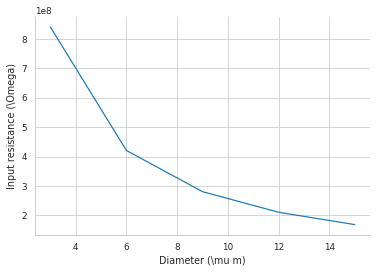

In [69]:
import seaborn as sns 
ax = sns.lineplot(diam_list, input_resistance_list)
ax.set(xlabel='Diameter (\mu m)', ylabel='Input resistance (\Omega)')

# aesthetics 
sns.set_context("paper")
sns.set_style("whitegrid")
sns.despine()

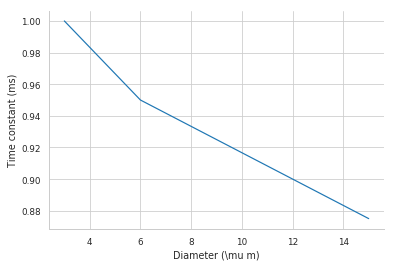

In [70]:
# time constant vs. diameter 
ax2 = sns.lineplot(diam_list, TauM_list)
ax2.set(xlabel='Diameter (\mu m)', ylabel='Time constant (ms)')

# aesthetics 
sns.despine()


## Adding dendrites and axons with increasing total area

In [7]:
import neuron 
from neuron import h, gui
dendrite_diam_list = [3, 6, 9, 12, 15]
axon_diam_list = [3, 6, 9, 12, 15] 

# neuron.h.delete_section(neuron.h.SectionLists)

soma = neuron.h.Section(name='soma') # set up a 'section'; abstract representation of a neuron, divided into segments
# all section goes from 0 to 1 (two different ends), and are divided into segments
dend = neuron.h.Section(name='dendrite') # dendrite
dend.connect(soma(1)) 

axon = neuron.h.Section(name='axon')
axon.connect(soma(0))

neuron.h.topology()
import matplotlib.pyplot as plt 
plt.figure()
s = neuron.h.PlotShape()
plt.show()

|-|       soma(0-1)
|-|       soma(0-1)
|-|       soma(0-1)
|-|       soma(0-1)
   `|       dendrite(0-1)
 `|       axon(0-1)



<Figure size 432x288 with 0 Axes>

In [5]:
from neuron import h, gui
soma = h.Section(name='soma')
axon = h.Section(name='axon')
dend = [h.Section(name='dend[%d]' % i) for i in range(3)]
for sec in dend:
    sec.connect(soma(1), 0)

h.topology()
s = h.Shape()

|-|       soma(0-1)
   `|       dend[0](0-1)
   `|       dend[1](0-1)
   `|       dend[2](0-1)
|-|       axon(0-1)



# Active properties

|-|       soma(0-1)
|-|       soma_hh(0-1)

[2.68249899e-316 6.91304410e-310 6.91304021e-310 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


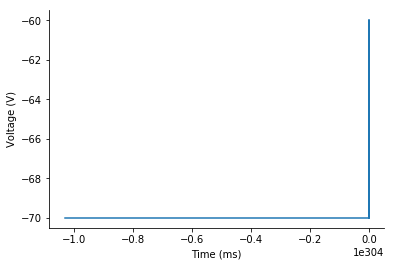

In [3]:
from neuron import h, gui
import neuron
soma_hh = h.Section(name='soma_hh')
soma_hh.insert('hh')
soma_hh.gnabar_hh = 0.12 # peak sodium conductance

# view cell structure 
h.topology()

# inject current

voltage_np, time_np = inject_current(somaLength = 12.6157,
somaDiam = 12.6157, stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25)


# plot 
import seaborn as sns 
ax = sns.lineplot(time_np, voltage_np)
ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
sns.despine()

print(time_np)
